# kNN Grundstruktur

#### Importe

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import ConnectionPatch
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
from sklearn.model_selection import GridSearchCV
from pathlib import Path

#### Import Plot Stylesheet

In [2]:
plt.style.use(['seaborn-v0_8-paper', Path.cwd().parent / 'plotstyle' / 'paper.mplstyle'])
cm = 1/2.54

#### Gleichgewichtsdaten importieren

In [3]:
eq_data_file = Path.cwd().parent / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten
res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Output xi
T = np.array(res['T'])
p = np.array(res['p'])
x_0 = np.array(res['x_0'])
x = np.array(res['x'])

#print(x_0)

X = np.stack((T, p, x_0[:,0], x_0[:,1], x_0[:,2]), axis = 1)
y = np.stack((x[:,0], x[:,2]), axis = 1) # [x_H2, x_NH3]
#print(X[:,0])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.8, random_state = 42)

#print(y_train)

#### Normalisierung

In [4]:
# Preprocessing Normalisierung der Daten
mean_in = np.mean(X_train, 0) # Mittelwert
std_in = np.std(X_train, 0) # Standardabweichung
mean_out = y_train.mean()
std_out = np.std(y_train, 0)

X_train = (X_train - mean_in) / std_in
y_train = (y_train - mean_out) / std_out

X_test = (X_test -mean_in) / std_in
y_test = (y_test - mean_out) / std_out

#### kNN Modell

In [5]:
k = 50 # Anzahl der nächsten Nachbarn
knn_model = KNeighborsRegressor(n_neighbors = k, weights = 'distance') # Initialisierung
knn_model.fit(X_train, y_train) # Fitten der Trainingsdaten

score_knn_train = knn_model.score(X_train, y_train)
score_knn_test = knn_model.score(X_test, y_test) # Bestimmtheitsmaß R^2 der Vorhersage
print('R^2 Train:', score_knn_train)
print('R^2 Test:', score_knn_test) 

R^2 Train: 1.0
R^2 Test: 0.929346711176956


#### Vorhersage Gleichgewichtsdaten, Error rate

In [6]:
# Vorhersage der Gleichgewichtsdaten
pred_train_norm = knn_model.predict(X_train)
pred_test_norm = knn_model.predict(X_test)

# Denormalisierung
pred_train = pred_train_norm * std_out + mean_out
real_train = y_train * std_out + mean_out
pred_test = pred_test_norm * std_out + mean_out
real_test = y_test * std_out + mean_out

# Performance
# performance_train = pd.DataFrame({ 'True Train Value': real_train, 'Train Prediction': pred_train, 'Train Error': real_train - pred_train})
# performance_test = pd.DataFrame({'True Test Value': real_test, 'Test Prediction': pred_test, 'Test Error': real_test - pred_test})

# print(performance_train)
# print(performance_test)

mae_train = (abs(real_train - pred_train)).mean()
mae_test = (abs(real_test - pred_test)).mean()
mre_train = (abs((real_train - pred_train) / real_train)).mean()
mre_test = (abs((real_test - pred_test) / real_test)).mean()
            
print('Train MAE:', mae_train, 'Train MRE:', mre_train, 'Test MAE:', mae_test, 'Test MRE:', mre_test)

Train MAE: 0.0 Train MRE: 0.0 Test MAE: 0.025549724804748163 Test MRE: 0.12510787395901432


#### Parity Plot

Training Dataset: R^2 = 1.0
Test Dataset: R^2 = 0.9293467111769561
Max Error Training: |x_H2 - x_H2_pred| = 0.0 |x_NH3 - x_NH3_pred| = 0.0
Max Error Test: |x_H2 - x_H2_pred| = 0.009929445316419816 |x_NH3 - x_NH3_pred| = 0.12847319090936005


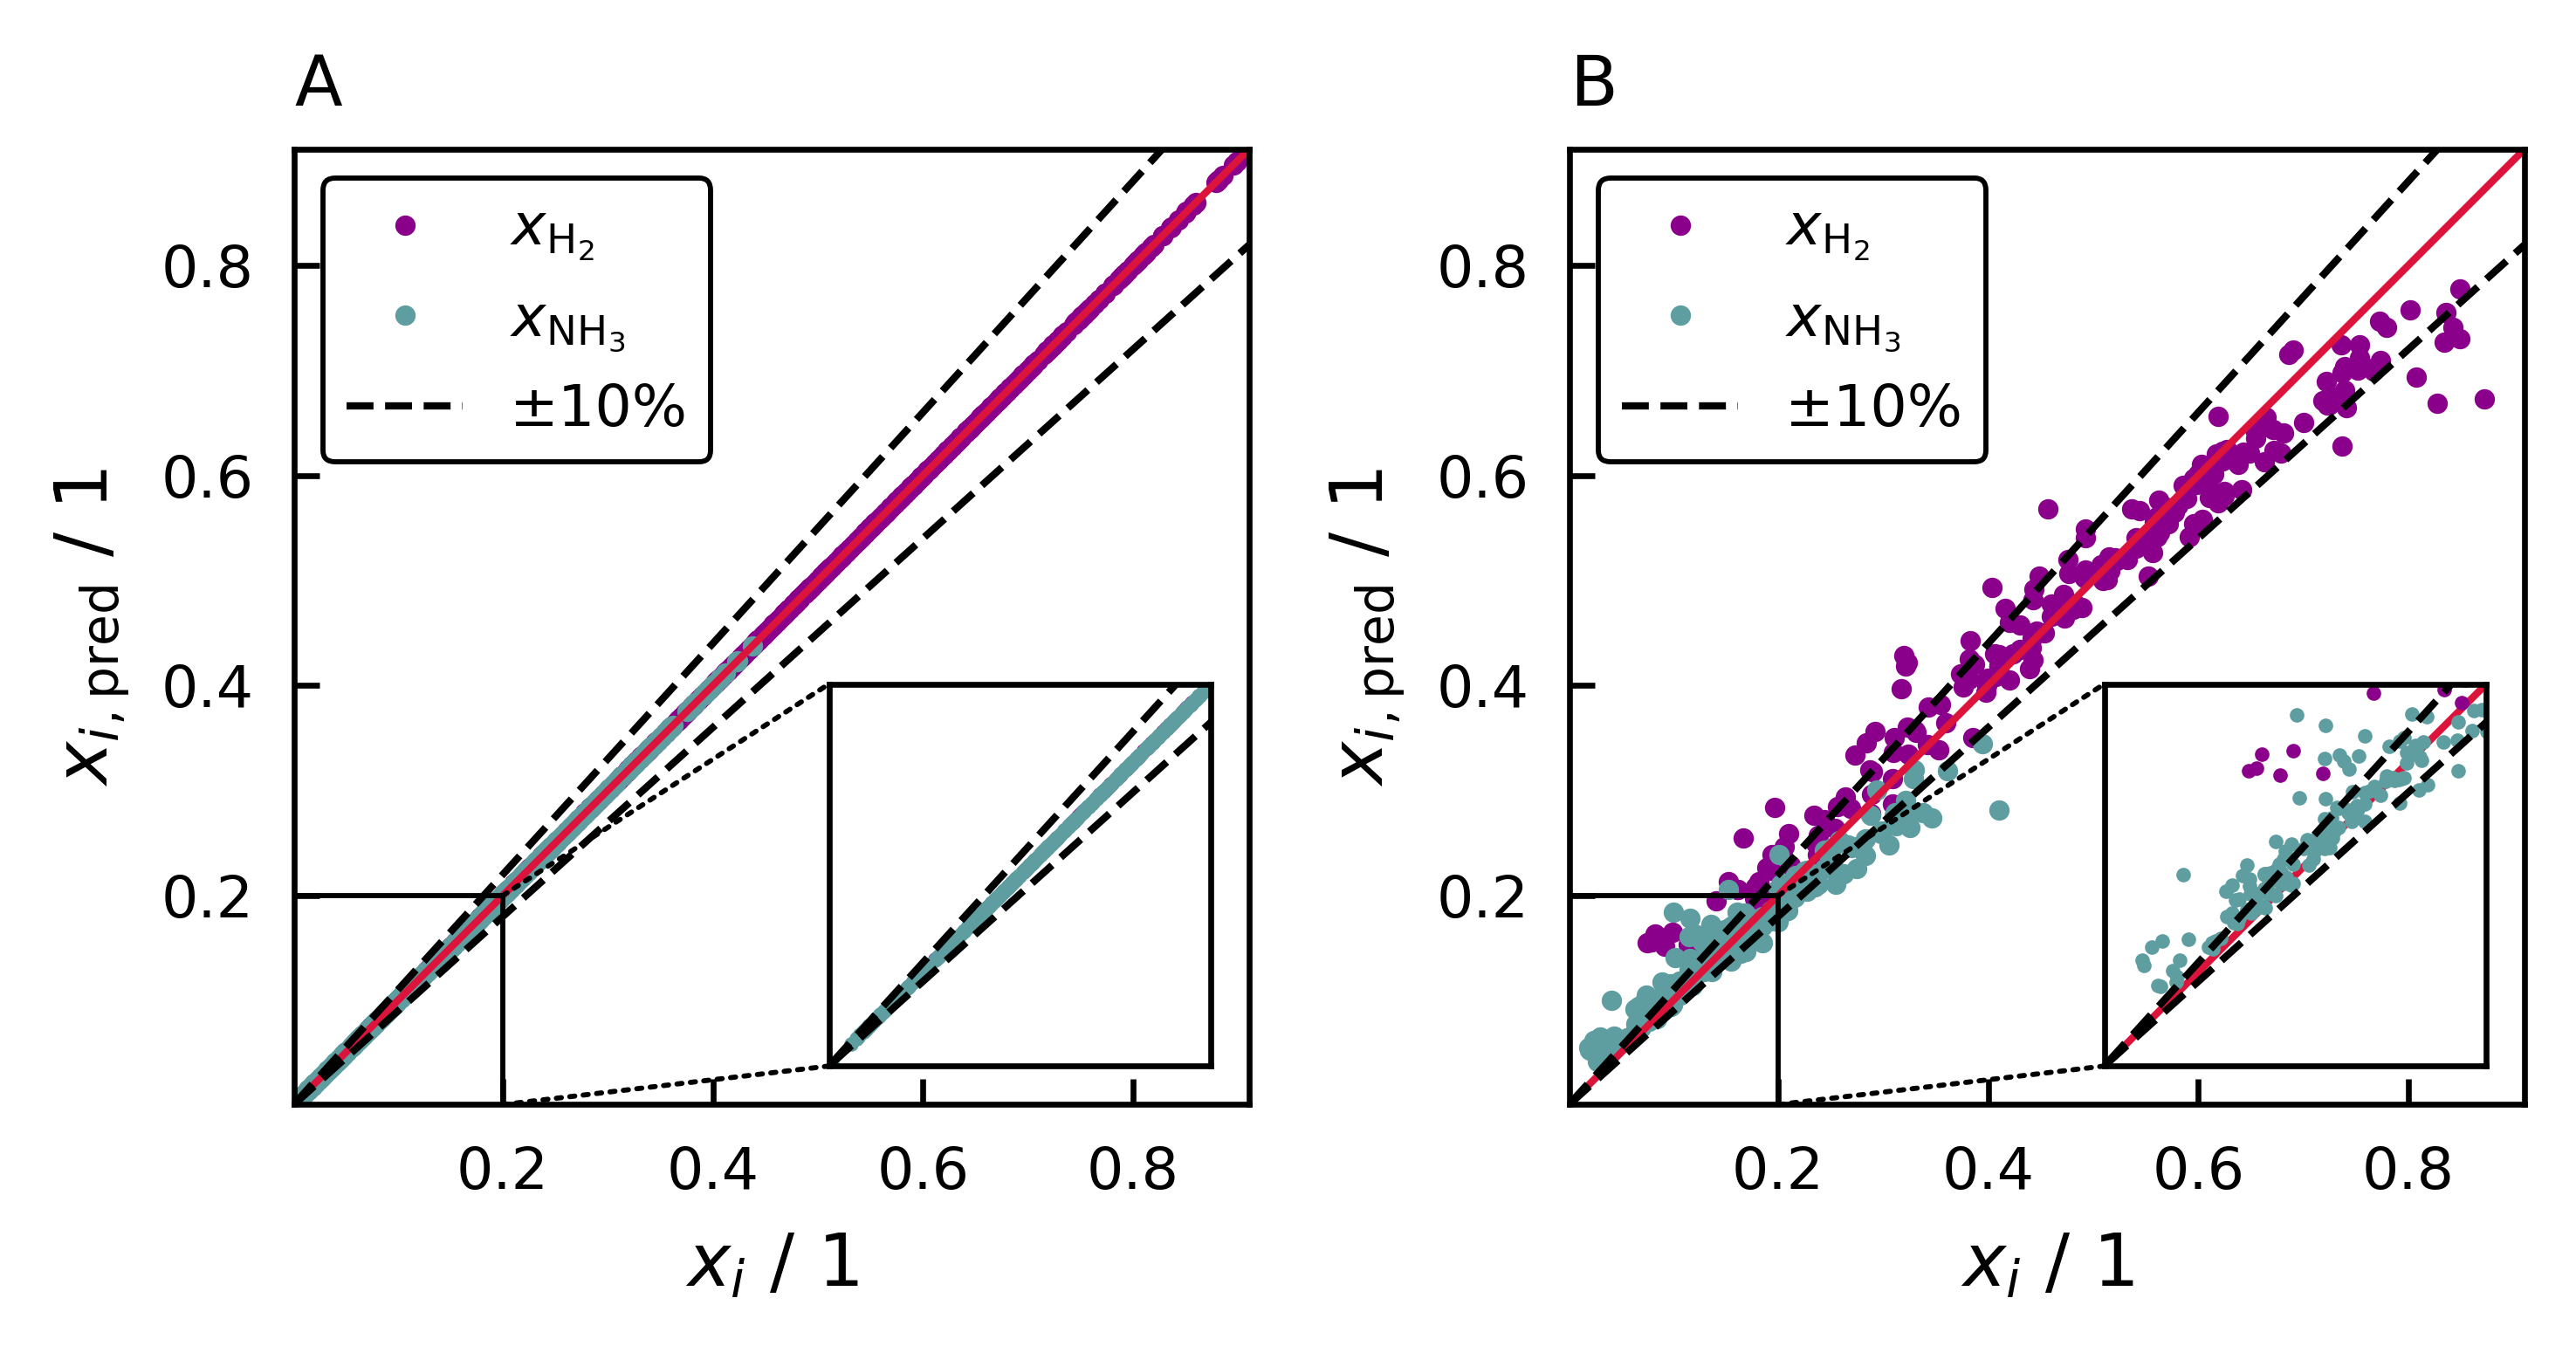

In [7]:
print('Training Dataset: R^2 =', r2(real_train,pred_train))
print('Test Dataset: R^2 =', r2(real_test,pred_test))
print('Max Error Training: |x_H2 - x_H2_pred| =', max_error(real_train[0], pred_train[0]), '|x_NH3 - x_NH3_pred| =', max_error(real_train[1], pred_train[1]))
print('Max Error Test: |x_H2 - x_H2_pred| =', max_error(real_test[0], pred_test[0]), '|x_NH3 - x_NH3_pred| =', max_error(real_test[1], pred_test[1]))

# find the boundaries of X and Y values
bounds = (min(real_train.min(), pred_train.min()) - int(0.1 * pred_train.min()), max(real_train.max(), pred_train.max())+ int(0.1 * pred_train.max()))

fig,ax = plt.subplots(1,2)#, figsize =(7.5*cm,7.5*cm))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(real_train, pred_train, '.', label = (['$x\mathregular{_{H_2}}$', '$x\mathregular{_{NH_3}}$']))
ax[0].plot([0, 1], [0, 1], "-", color = 'crimson', lw=1 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1]*1.1], "k--", lw=1, label = ('\xb1' '10%')) # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1]*0.9], "k--",lw=1) # Error line
ax[0].set(xlabel = '$x_i$ / 1', ylabel = '$x_i\mathregular{_{,pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('A', loc='left')
ax[0].legend()

#inset axes
x1,x2,y1,y2 = 0, 0.2, 0, 0.2 # subregion of origanal image
axin0 = ax[0].inset_axes([0.56, 0.04, 0.4, 0.4], xlim=(x1,x2), ylim=(y1,y2), xticks=[], yticks=[], xticklabels=[], yticklabels=[])

axin0.plot(real_train, pred_train, '.', markersize = 4)
#axin0.plot(x_NH3_real, x_NH3_pred, '.', markersize = 4)
axin0.plot([0, 1], [0, 1], "-", color = 'crimson',lw=1,zorder=1 )
axin0.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=1)
axin0.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=1)

rect = (x1, y1, x2 - x1, y2 - y1)
box2= ax[0].indicate_inset(rect, edgecolor="black", alpha=1,lw=0.7)

cp1 = ConnectionPatch(xyA=(0.2, 0.001), xyB=(0, 0), axesA=ax[0], axesB=axin0,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)
cp2 = ConnectionPatch(xyA=(0.2, 0.2), xyB=(0, 1), axesA=ax[0], axesB=axin0,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)

ax[0].add_patch(cp1)
ax[0].add_patch(cp2)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(real_test, pred_test, '.', label = (['$x\mathregular{_{H_2}}$', '$x\mathregular{_{NH_3}}$']))
ax[1].plot([0, 1], [0, 1], "-", color='crimson',lw=1 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1]*1.1], "k--", lw=1, label = ('\xb1' '10%')) # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1]*0.9], "k--",lw=1) # Error line
ax[1].set(xlabel = '$x_i$ / 1', ylabel = '$x_i\mathregular{_{,pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('B', loc='left')
ax[1].legend()

#inset axes
x1,x2,y1,y2 = 0, 0.2, 0, 0.2 # subregion of origanal image
axin1 = ax[1].inset_axes([0.56, 0.04, 0.4, 0.4], xlim=(x1,x2), ylim=(y1,y2), xticks=[], yticks=[], xticklabels=[], yticklabels=[])

axin1.plot(real_test, pred_test, '.', markersize = 4)
#axin1.plot(x_NH3_real_test, x_NH3_pred_test, '.', markersize = 4)
axin1.plot([0, 1], [0, 1], "-", color = 'crimson',lw=1,zorder=1 )
axin1.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=1)
axin1.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=1)

rect = (x1, y1, x2 - x1, y2 - y1)
box1= ax[1].indicate_inset(rect, edgecolor="black", alpha=1,lw=0.7)

cp1 = ConnectionPatch(xyA=(0.2, 0.001), xyB=(0, 0), axesA=ax[1], axesB=axin1,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)
cp2 = ConnectionPatch(xyA=(0.2, 0.2), xyB=(0, 1), axesA=ax[1], axesB=axin1,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)

ax[1].add_patch(cp1)
ax[1].add_patch(cp2)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()